==============================================================================================

&lsaquo; GPMIntro.ipynb  &rsaquo;
Copyright (C) &lsaquo; 2017 &rsaquo;  &lsaquo; Anna Scaife - anna.scaife@manchester.ac.uk &rsaquo;

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

==============================================================================================




[AMS - 170402]  Notebook created for SKA-SA Newton Big Data Summer School, Cape Town , April 2017.
--

This notebook is an extended version of the notebook "GPMIntro.ipynb". This notebook uses GPM to predict a signal.  It recreates some of the plots from Roberts et al. 2013 (http://www.robots.ox.ac.uk/~sjrob/Pubs/Phil.%20Trans.%20R.%20Soc.%20A-2013-Roberts-.pdf). 

It extends the original notebook to show how to fit maximum likelihood hyper-parameters to covariance kernels using a combination of the **george** library (http://dan.iel.fm/george/current/) and the **emcee** library (http://dan.iel.fm/emcee/current/).

It is a teaching resource and is accompanied by the lecture "Can you Predict the Future..?".

All Python libraries used in this example can be installed using **pip**.

---------------------------------------------------------------------------------------------

To start let's specify that we want our figures to appear embedded in the notebook:

In [1]:
#%matplotlib inline

Then let's import all the libraries we need...

In [2]:
import numpy as np
import pylab as pl
from scipy import linalg as sl

Make the covariance kernel a squared-exponential,

$k(x_1,x_2) = h^2 \exp{ \left( \frac{-(x_1 - x_2)^2}{\lambda^2} \right)}$,

just like Eq. 3.11 in Roberts et al. (2012).

http://www.robots.ox.ac.uk/~sjrob/Pubs/Phil.%20Trans.%20R.%20Soc.%20A-2013-Roberts-.pdf

In [3]:
def cov_kernel(x1,x2,h,lam):
    """
    Squared-Exponential covariance kernel
    """
    k12 = h**2*np.exp(-1.*(x1 - x2)**2/lam**2)
    
    return k12

We can use this kernel to calculate  the value of each element in our covariance matrix:

$\mathbf{K(x,x)} = \left(
\begin{array}{cccc}
k(x_1,x_1) & k(x_1,x_2) & ... & k(x_1,x_n) \\
k(x_2,x_1) & k(x_2,x_2) & ... & k(x_2,x_n) \\
\vdots & \vdots & \vdots & \vdots \\
k(x_n,x_1) & k(x_n,x_2) & ... & k(x_n,x_n) 
\end{array}
\right).$

We can then populate a covariance matrix, $K(\mathbf{x},\mathbf{x})$, for our data:

In [4]:
def make_K(x, h, lam):
    
    """
    Make covariance matrix from covariance kernel
    """
    
    # for a data array of length x, make a covariance matrix x*x:
    K = np.zeros((len(x),len(x)))
    
    for i in range(0,len(x)):
        for j in range(0,len(x)):
            
            if (i==j):
                noise = 1e-5
            else:
                noise = 0.0
            
            # calculate value of K for each separation:
            K[i,j] = cov_kernel(x[i],x[j],h,lam) + noise**2
            
    return K

In [8]:
def make_identity(x):
    K = np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        K[i,i] = 1
    
    return K

Using this kernel we can then recreate Fig. 5 from Roberts et al. (2012).

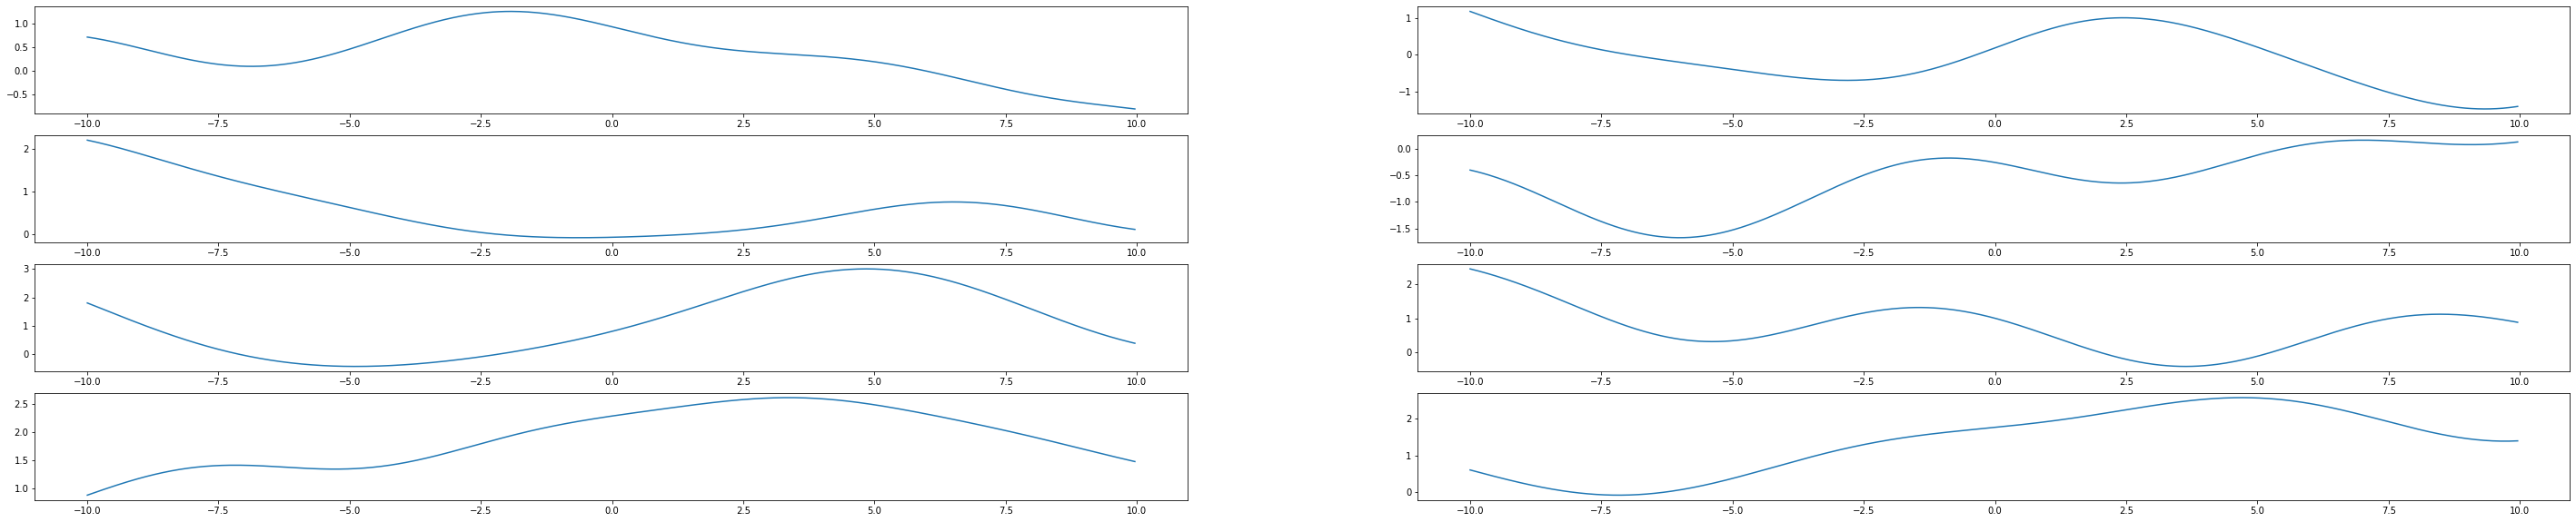

In [37]:
# make an array of 200 evenly spaced positions between 0 and 20:
x1 = np.arange(-10., 10., 0.04)

pl.figure(figsize=(50, 10))
for i in range(0,1):
    
    h = 1.0
    
#     if (i==0): lam = 0.1
#     if (i==1): lam = 1.0
    if (i==0): lam = 5.0
        
    # make a covariance matrix:
    K = make_K(x1,h,lam)
#     K = make_identity(x1)
    K_1 = np.ones((len(x1), len(x1)))
    
    # five realisations:
    for j in range(0,4):
        
        # draw samples from a co-variate Gaussian distribution, N(0,K):
        y1 = np.random.multivariate_normal(np.zeros(len(x1)),K)
        
        tmp2 = '42'+str(i+1+j)
        pl.subplot(int(tmp2))
        pl.plot(x1,y1)
        
    # five realisations:
    for j in range(0,4):
        
        # draw samples from a co-variate Gaussian distribution, N(0,K):
        y1 = np.random.multivariate_normal(np.ones(len(x1)),K)
    
        tmp2 = '42'+str(i+5+j)
        pl.subplot(int(tmp2))
        pl.plot(x1,y1)
        
#     for j in range(0,4):
        
#         # draw samples from a co-variate Gaussian distribution, N(0,K):
#         y1 = np.random.multivariate_normal(np.zeros(len(x1)),K_1)
    
#         tmp2 = '42'+str(i+1+j)
#         pl.subplot(int(tmp2))
#         pl.plot(x1,y1)
#         pl.ylim(-3, 3)
    
#     for j in range(0,4):
        
#         # draw samples from a co-variate Gaussian distribution, N(0,K):
#         y1 = np.random.multivariate_normal(np.ones(len(x1)),K_1)
    
#         tmp2 = '42'+str(i+5+j)
#         pl.subplot(int(tmp2))
#         pl.plot(x1,y1)
#         pl.ylim(-3, 3)
        
        
#     tmp1 = '12'+str(i+1)
#     pl.subplot(int(tmp1))
#     pl.imshow(K)
#     pl.title(r"$\lambda = $"+str(lam))
    
    
pl.show()

If we then take the final realization, which has $\lambda = 5$, and select 5 points from it randomly we can calculate the posterior mean and variance at every point based on those five input data. 

The mean and variance are given by Eq. 3.8 & 3.9 in Roberts et al. (2012) or Eq. 2.25 & 2.26 in Rasmussen & Williams.

First let's select our  **training data points** and our **test data points**:

In [38]:
# set number of training points
nx_training = 5

# randomly select the training points:
tmp = np.random.uniform(low=0.0, high=500.0, size=nx_training)
tmp = tmp.astype(int)

condition = np.zeros_like(x1)
for i in tmp: condition[i] = 1.0
    
y_train = y1[np.where(condition==1.0)]
x_train = x1[np.where(condition==1.0)]
y_test = y1[np.where(condition==0.0)]
x_test = x1[np.where(condition==0.0)]

We then use our **training data points** to define a covariance matrix:

In [39]:
# define the covariance matrix:
K = make_K(x_train,h,lam)

# take the inverse:
iK = np.linalg.inv(K)

print('determinant: ',np.linalg.det(K), sl.det(K))

determinant:  1.0396370654645295e-07 1.0396370654645282e-07


For each of our **test data points** we can then make a prediction of the value at $x_{\ast}$ and the uncertainly (standard deviation):

In [58]:
def make_K2(x1, x2, h, lam):
    
    """
    Make covariance matrix from covariance kernel
    """
    
    # for a data array of length x, make a covariance matrix x*x:
    K = np.zeros((len(x1),len(x2)))
    
    for i in range(0,len(x1)):
        for j in range(0,len(x2)):
            
            if (i==j):
                noise = 1e-5
            else:
                noise = 0.0
            
            # calculate value of K for each separation:
            K[i,j] = cov_kernel(x1[i],x2[j],h,lam) + noise**2
            
    return K

mu=[];sig=[]
for xx in x_test:

    # find the 1d covariance matrix:
    K_x = cov_kernel(xx, x_train, h, lam)
    
    # find the kernel for (x,x):
    k_xx = cov_kernel(xx, xx, h, lam)
    
    # calculate the posterior mean and variance:
    mu_xx = np.dot(K_x.T,np.dot(iK,y_train))
    sig_xx = k_xx - np.dot(K_x.T,np.dot(iK,K_x))
    
    mu.append(mu_xx)
    sig.append(np.sqrt(np.abs(sig_xx))) # note sqrt to get stdev from variance

mu = np.array(mu)
k_ii = make_K(x_test, 1, 5)
k_jj = make_K(x_train, 1, 5)
k_ij = make_K2(x_test, x_train, 1, 5)
ik_jj = np.linalg.inv(k_jj)
sig_i_j = k_ii - np.dot(k_ij,np.dot(ik_jj, k_ij.T))

(495, 495)
(495,)
[0.56249641 0.5496955  0.53682794 0.52390137 0.51092349 0.49790207
 0.48484498 0.47176011 0.45865543 0.44553895 0.43241872 0.41930283
 0.40619941 0.39311661 0.38006259 0.36704553 0.35407362 0.34115505
 0.32829799 0.31551063]
(495, 495)
(495,)
[0.56249641 0.5496955  0.53682794 0.52390137 0.51092349 0.49790207
 0.48484498 0.47176011 0.45865543 0.44553895 0.43241872 0.41930283
 0.40619941 0.39311661 0.38006259 0.36704553 0.35407362 0.34115505
 0.32829799 0.31551063]
(495, 495)
(495,)
[0.56249641 0.5496955  0.53682794 0.52390137 0.51092349 0.49790207
 0.48484498 0.47176011 0.45865543 0.44553895 0.43241872 0.41930283
 0.40619941 0.39311661 0.38006259 0.36704553 0.35407362 0.34115505
 0.32829799 0.31551063]
(495, 495)
(495,)
[0.56249641 0.5496955  0.53682794 0.52390137 0.51092349 0.49790207
 0.48484498 0.47176011 0.45865543 0.44553895 0.43241872 0.41930283
 0.40619941 0.39311661 0.38006259 0.36704553 0.35407362 0.34115505
 0.32829799 0.31551063]


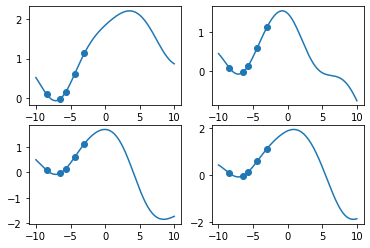

In [61]:

for i in range(4):
    print(sig_i_j.shape)
    print(mu.shape)
    print(mu[:20])
    y_dist = np.random.multivariate_normal(mu, sig_i_j)
    pl.subplot(int('22' + str(i+1)))
    pl.scatter(x_train, y_train)  # plot the training points
    pl.plot(x_test, y_dist)
    
pl.show()
    

Let's plot this up:

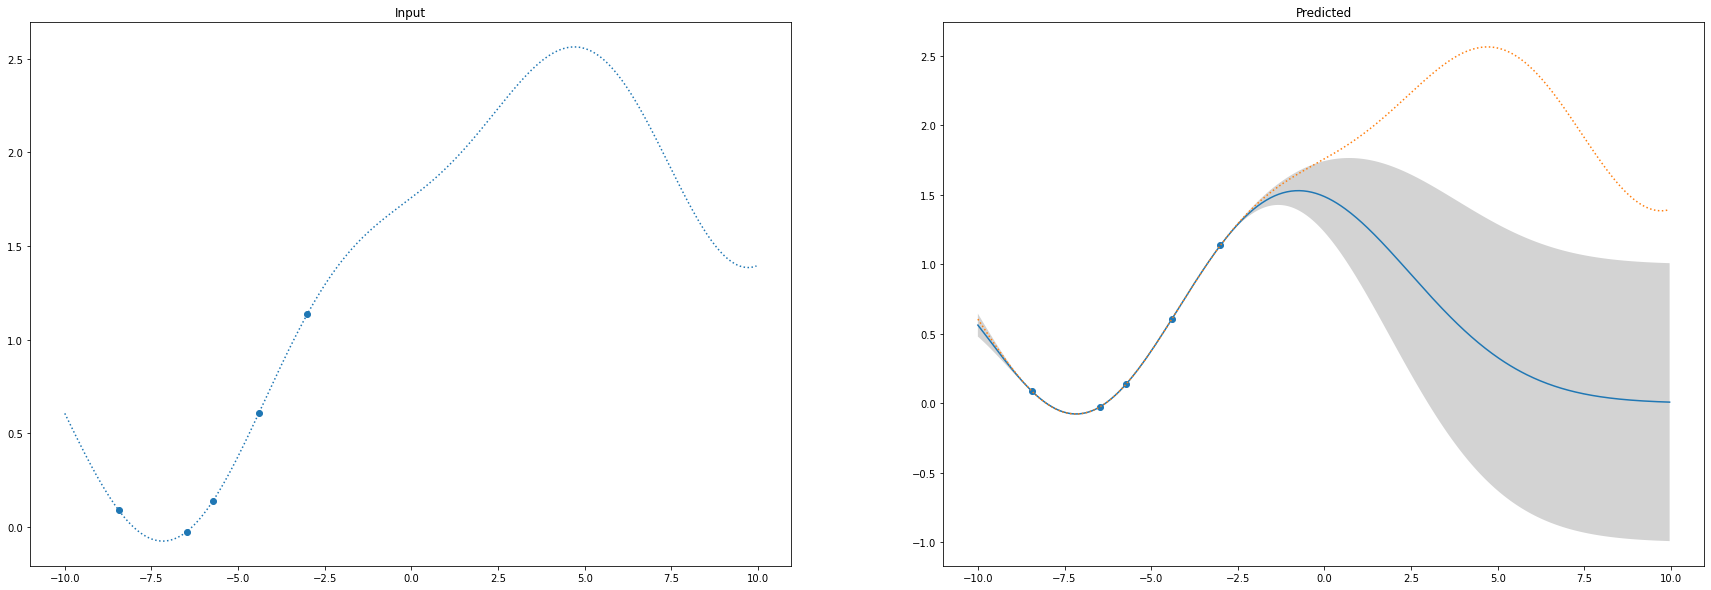

In [41]:
# mu and sig are currently lists - turn them into numpy arrays:
mu=np.array(mu);sig=np.array(sig)

# make some plots:

pl.figure(figsize=(30,10))
# left-hand plot
ax = pl.subplot(121)
pl.scatter(x_train,y_train)  # plot the training points
pl.plot(x1,y1,ls=':')        # plot the original data they were drawn from
pl.title("Input")

# right-hand plot
ax = pl.subplot(122)
pl.plot(x_test,mu,ls='-')     # plot the predicted values
pl.plot(x_test,y_test,ls=':') # plot the original values


# shade in the area inside a one standard deviation bound:
ax.fill_between(x_test,mu-sig,mu+sig,facecolor='lightgrey', lw=0, interpolate=True)
pl.title("Predicted")

pl.scatter(x_train,y_train)  # plot the training points

# display the plot:
pl.show()

[Note: Depending on  the selection of training points you might want to specify some axis ranges for these plots]

At this point we've come to the end of the material presented in the lecture.

--END--

Extra material
--

What if we don't know the values of the hyper-parameters in our covariance kernel? We can fit them directly from the data!

In [ ]:
# set number of training points
frac = 0.05
nx_training = int(len(x1)*frac)
print "Using ",nx_training," points."

# randomly select the training points:
tmp = np.random.uniform(low=0.0, high=2000.0, size=nx_training)
tmp = tmp.astype(int)

condition = np.zeros_like(x1)
for i in tmp: condition[i] = 1.0
    
y_train = y1[np.where(condition==1.0)]
x_train = x1[np.where(condition==1.0)]
y_test = y1[np.where(condition==0.0)]
x_test = x1[np.where(condition==0.0)]

In [ ]:
pl.scatter(x_train,y_train)  # plot the training points
pl.plot(x1,y1,ls=':')        # plot the original data they were drawn from
pl.title("Training Data")
pl.show()

For what follows I'm going to use the **george** library. The main reason for this is that the matrix inversion in **numpy** is not very stable for large (> (10 x 10)) matrices. 

In [ ]:
import george
from george import kernels

In [ ]:
import emcee

# we need to define three functions: 
# a log likelihood, a log prior & a log posterior.

# set the loglikelihood:
def lnlike2(p, x, y):
    
    # update kernel parameters:
    gp.kernel[:] = p
    
    # compute covariance matrix:
    gp.compute(x)
    
    # calculate the likelihood:
    ll = gp.lnlikelihood(y, quiet=True)
    
    # return 
    return ll if np.isfinite(ll) else 1e25

# set the logprior
def lnprior2(p):
    
    # note that "p" contains the ln()
    # of the parameter values - set your
    # prior ranges appropriately!
    
    lnh,lnlam,lnsig = p
    
    # really crappy prior:
    if (-2.<lnh<5.) and (-1.<lnlam<10.) and (-30.<lnsig<0.):
        return 0.0
    
    return -np.inf

# set the logposterior:
def lnprob2(p, x, y):
    
    lp = lnprior2(p)
    
    return lp + lnlike2(p, x, y) if np.isfinite(lp) else -np.inf


# initiate george with the exponential squared kernel:
kernel = 1.0*kernels.ExpSquaredKernel(30.0)+kernels.WhiteKernel(1e-5)
gp = george.GP(kernel, mean=0.0)

# put all the data into a single array:
data = (x_train,y_train)

# set your initial guess parameters
# remember george keeps these in ln() form!
initial = gp.kernel[:]
print "Initial guesses: ",np.exp(initial)

# set the dimension of the prior volume 
# (i.e. how many parameters do you have?)
ndim = len(initial)
print "Number of parameters: ",ndim

# The number of walkers needs to be more than twice 
# the dimension of your parameter space... unless you're crazy!
nwalkers = 10

# perturb your inital guess parameters very slightly
# to get your starting values:
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim)
      for i in xrange(nwalkers)]

# initalise the sampler:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=data)

# run a few samples as a burn-in:
print("Running burn-in")
p0, lnp, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()

# take the highest likelihood point from the burn-in as a
# starting point and now begin your production run:
print("Running production")
p = p0[np.argmax(lnp)]
p0 = [p + 1e-4 * np.random.randn(ndim) for i in xrange(nwalkers)]
p0, _, _ = sampler.run_mcmc(p0, 8000)

print "Finished"

In [ ]:
import acor

# calculate the convergence time of our
# MCMC chains:
samples = sampler.flatchain
s2 = np.ndarray.transpose(samples)
tau, mean, sigma = acor.acor(s2)
print "Convergence time from acor: ", tau

# get rid of the samples that were taken
# before convergence:
delta = int(20*tau)
samples = sampler.flatchain[delta:,:]

# extract the log likelihood for each sample:
lnl = sampler.flatlnprobability[delta:]

# find the point of maximum likelihood:
ml = samples[np.argmax(lnl),:]

# print out those values
# Note that we have unwrapped 
print "ML parameters: ", 
print "h: ", np.sqrt(np.exp(ml[0]))," ; lam: ",np.sqrt(np.exp(ml[1]))," ; sigma: ",np.sqrt(np.exp(ml[2]))

Note that the george **ExpSquaredKernel** has a factor of two in the denominator of the exponent. So whereas we specified that  $\lambda_{\rm true} = 5.0$, we have found that $\lambda_{\rm fit} = 3.46$...  (or similar)

Is this what we should expect given the extra factor of two? Well, 25/2 = 12.5 and $\sqrt{12.5} =  \dots 3.54$, so we're pretty close!

Let's plot our probability surfaces for each pair of parameters, as well as the confidence intervals:

In [ ]:
import corner

# Plot it.
figure = corner.corner(samples, labels=[r"$\ln(h^2)$", r"$\ln(\lambda^2)$", r"$\ln(\sigma^2)$"],
                         truths=ml,
                         quantiles=[0.16,0.5,0.84],
                         #levels=[0.39,0.86,0.99],
                         levels=[0.68,0.95,0.99],
                         title="Mauna Loa Data",
                         show_titles=True, title_args={"fontsize": 12})

We  can also extract the **expectation** value for each parameter and the individual confidence intervals:

In [ ]:
q1 = corner.quantile(samples[:,0],
						 q=[0.16,0.5,0.84])

print "Parameter 1: ",q1[1],"(-",q1[1]-q1[0],", +",q1[2]-q1[1],")"

q2 = corner.quantile(samples[:,1],
						 q=[0.16,0.5,0.84])

print "Parameter 2: ",q2[1],"(-",q2[1]-q2[0],", +",q2[2]-q2[1],")"

q3 = corner.quantile(samples[:,2],
						 q=[0.16,0.5,0.84])

print "Parameter 3: ",q2[1],"(-",q2[1]-q2[0],", +",q2[2]-q2[1],")"

